In [ ]:
#Libraries used in data science
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

#Set Plot format
plt.style.use('ggplot')

In [ ]:
#Read in data. I am reading in a data set I found on Kaggle which contains marathon finish times. I will do some general exploration of the data
#and then ultimately try to answer the question, at what age do marathon runners achieve peak performance?

df = pd.read_csv('assets/parsed_marathon_data_4.csv')
#Check the data has been read in properly
df.head()

,marathon_name,raw_results,num_finishers,name,gender,age,age_inference,time,time_total_minutes,marathon_state,marathon_date,marathon_year,marathon_month
0,Christmas Marathon (WA - 12/17/00),Craig Vanderoef (M26) 2:49:35 1 1 / 1 M25-29 S...,64,Craig Vanderoef,M,26,False,2:49:35,169,WA,2000-12-17,2000.0,12.0
1,Christmas Marathon (WA - 12/17/00),Todd Petrovich (M23) 3:06:39 2 2 / 1 M20-24 Tr...,64,Todd Petrovich,M,23,False,3:06:39,186,WA,2000-12-17,2000.0,12.0
2,Christmas Marathon (WA - 12/17/00),Wesley Smith (M29) 3:08:51 3 3 / 2 M25-29 Nort...,64,Wesley Smith,M,29,False,3:08:51,188,WA,2000-12-17,2000.0,12.0
3,Christmas Marathon (WA - 12/17/00),Mike Gangwer (M48) 3:09:46 4 4 / 1 M45-49 Keiz...,64,Mike Gangwer,M,48,False,3:09:46,189,WA,2000-12-17,2000.0,12.0
4,Christmas Marathon (WA - 12/17/00),Philip Marcus (M29) 3:13:05 5 5 / 3 M25-29 Ren...,64,Philip Marcus,M,29,False,3:13:05,193,WA,2000-12-17,2000.0,12.0


In [5]:
#Get a basic overview of the data set to know what it contains
print(df.dtypes)
print('')
print('size:')
print(df.shape)

marathon_name          object
raw_results            object
num_finishers           int64
name                   object
gender                 object
age                    object
age_inference            bool
time                   object
time_total_minutes      int64
marathon_state         object
marathon_date          object
marathon_year         float64
marathon_month        float64
dtype: object

size:
(209025, 13)


In [7]:
#Some basic data cleaning is necessary, I'll remove some columns not needed, and convert some column data types
df.columns

Index(['marathon_name', 'raw_results', 'num_finishers', 'name', 'gender',
       'age', 'age_inference', 'time', 'time_total_minutes', 'marathon_state',
       'marathon_date', 'marathon_year', 'marathon_month'],
      dtype='object')

In [9]:
#I'll copy paste columns in and comment out results not needed
df = df[[#'marathon_name', 'raw_results', 
    'num_finishers', #'name', 
    'gender', 'age', #'age_inference', 
    'time', 'time_total_minutes', 'marathon_state',
       'marathon_date', 'marathon_year', 'marathon_month'
    ]].copy()

In [11]:
#Variables like age, year and month I see should all contain int values only. I will convert them
df['age'] = pd.to_numeric(df['age'], errors ='coerce')
df['age'] = df['age'].fillna(0).astype(int)

df['marathon_year'] = df['marathon_year'].fillna(0).astype(int)
df['marathon_month'] = df['marathon_month'].fillna(0).astype(int)
df.dtypes

num_finishers          int64
gender                object
age                    int32
time                  object
time_total_minutes     int64
marathon_state        object
marathon_date         object
marathon_year          int32
marathon_month         int32
dtype: object

In [13]:
# Use describe function to get a rough sense of the data. Looks like we can go ahead with analysis.
df.describe()

,num_finishers,age,time_total_minutes,marathon_year,marathon_month
count,209025.000000,209025.000000,209025.000000,209025.000000,209025.000000
mean,1037.413467,36.168444,233.642244,1841.560148,6.588155
std,3383.233363,15.565979,62.421444,560.093028,3.640927
min,1.000000,0.000000,109.000000,0.000000,0.000000
25%,105.000000,29.000000,191.000000,2005.000000,4.000000
50%,229.000000,38.000000,218.000000,2010.000000,7.000000
75%,644.000000,46.000000,260.000000,2015.000000,10.000000
max,49828.000000,99.000000,1411.000000,2021.000000,12.000000


In [185]:
#I will check for any weirdly fast or slow times that can be removed:
df = df.sort_values(by=['time_total_minutes'], ascending=True)
df

,num_finishers,gender,age,time,time_total_minutes,marathon_state,marathon_date,marathon_year,marathon_month
364,2308,M,46,1:49:12,109,FL,2000-12-10,2000,12
366,2308,M,35,2:02:43,122,FL,2000-12-10,2000,12
182623,35596,bad_record,0,2:04:01,124,-,2021-10-03,2021,10
182624,35596,bad_record,0,2:04:28,124,-,2021-10-03,2021,10
182625,35596,bad_record,0,2:04:41,124,-,2021-10-03,2021,10
...,...,...,...,...,...,...,...,...,...
127576,69,F,37,13:56:19,836,KS,2015-09-12,2015,9
35335,52,F,53,14:01:00,841,MA,2005-07-29,2005,7
123430,38,M,49,14:41:00,881,MI,2015-09-26,2015,9
35336,52,M,53,16:19:04,979,MA,2005-07-29,2005,7


In [187]:
#I see some people with age 0, I also se some unreasonably fast and slow races. Most races would not allow runners to continue after 10+ hours.
#Age may be self reported so I will also remove unreasonable ages

df = df[df['age'] > 14]
df = df[df['age'] < 80] 

df = df[df['time_total_minutes'] > 123]
df = df[df['time_total_minutes'] < 600]

In [336]:
# Now we can do some preliminary plotting. I would like to visualize the total times to get a sense of the type of distribution of the data

# I will create a count column for each of the total times.
times = df.groupby(['time_total_minutes']).size().to_frame('count')

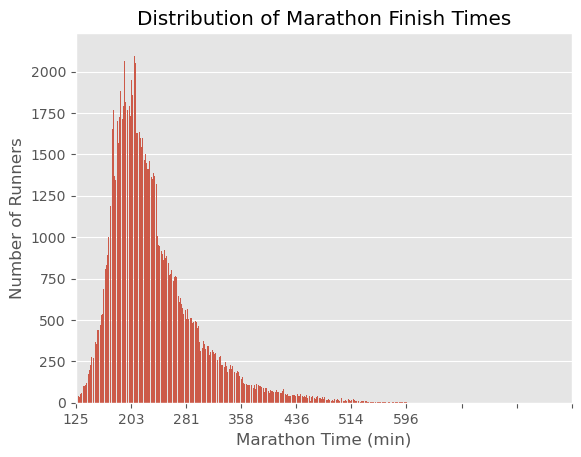

In [324]:
# Plot all times within data set to see shape of data.

axis = sns.barplot(x='time_total_minutes', y='count', data=times)
axis.set_xlim(0,700)
axis.xaxis.set_major_locator(ticker.LinearLocator(10))
plt.xlabel('Marathon Time (min)')
plt.ylabel('Number of Runners')
plt.title('Distribution of Marathon Finish Times')
plt.show()

# Interestingly it seems like the result time may be normally distributed. To test this I will plot a gaussean best fit over the data to see how 
# close to normally distributed the data is.

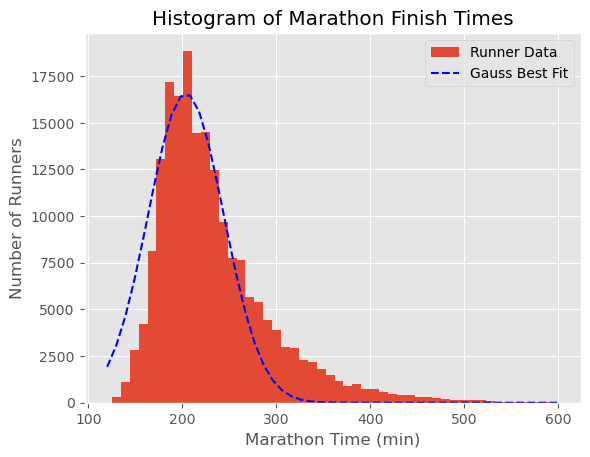

[675.92639474   1.90069468   1.94280363]


In [418]:
#First I will create a histogram to represent the data
n,bins,patches = plt.hist(df['time_total_minutes'],bins=50, label='Runner Data')

#I will need to create a python function to represent the Gaussian Function to represent normally distributed data.
def gauss(x, amp, mu, sigma):
    return amp*np.exp(-(x-mu)**2/(2*sigma**2))

#I will need to define the x space the best fit will occupy, and the number of bins it will represent.
# The data runs from roughly 2 hrs (120 min) to 10 hours (600 min), and I have selected to represent the data with 50 bins.
x = np.linspace(120,600,50)

# Earlier I defined n as the y value or height of the histogram
y_hist = n

# Next I will use built in scipy curve fit function which will return the area of the optimize parameter as well as the covariance
# I will provide that function with the previously defined gaussian function, the x range I defined for it, the heights of the histogram,
# and an argument which contains the amplitude of the histogram, the mean point of the data, and the number of bins
popt,pcov = curve_fit(gauss,x,y_hist,p0=(18500,230,50))
# This will generate popt values that can be fed into the gaussean function
y = gauss(x,popt[0],popt[1],popt[2])

#Format Plot
plt.plot(x,y,color='b',linestyle='dashed', label = 'Gauss Best Fit')
plt.xlabel('Marathon Time (min)')
plt.ylabel('Number of Runners')
plt.title('Histogram of Marathon Finish Times')
plt.legend()
plt.show()

# I can also use the covariance output to check how accurately the best fit represents the data by taking the square root of the diagnol
# of the pcov array that is produced. The lower the values, the better the fit represents the data
print(np.sqrt(np.diag(pcov)))

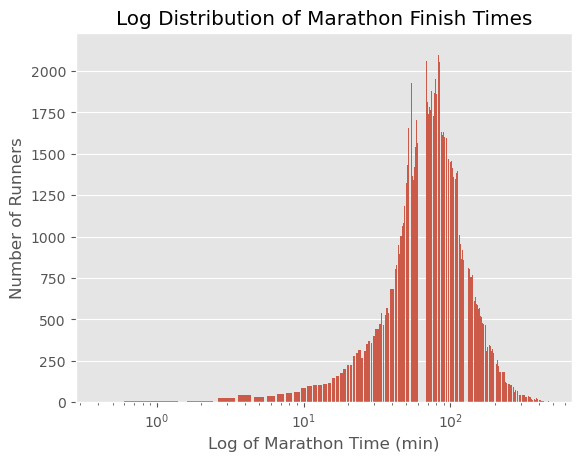

In [421]:
# It appears the number of runners rises to the highest point quickly and then trails off more slowly. This may mean that marathon times can actually
# be represented log normally. I will apply a log scale to the x axis to see if the data becomes more normally distributed

axis = sns.barplot(x='time_total_minutes', y='count', data=times)
axis.set(xscale="log")
plt.xlabel('Log of Marathon Time (min)')
plt.ylabel('Number of Runners')
plt.title('Log Distribution of Marathon Finish Times')
plt.show()

# The data does not look quite log normally distributed either. 

In [197]:
# With the initial data exploration complete I would now like to answer a question, when is the peak age for marathon running? Is there a different
# age for female and male runners?

# Creating a male and female only data set
male = df[df['gender'] == 'M']
female = df[df['gender'] == 'F']

In [199]:
#Find the mean finish time of each age

avg_all = df.groupby('age', as_index=False).agg({'time_total_minutes': 'mean'})
avg_male = male.groupby('age', as_index=False).agg({'time_total_minutes': 'mean'})
avg_female = female.groupby('age', as_index=False).agg({'time_total_minutes': 'mean'})

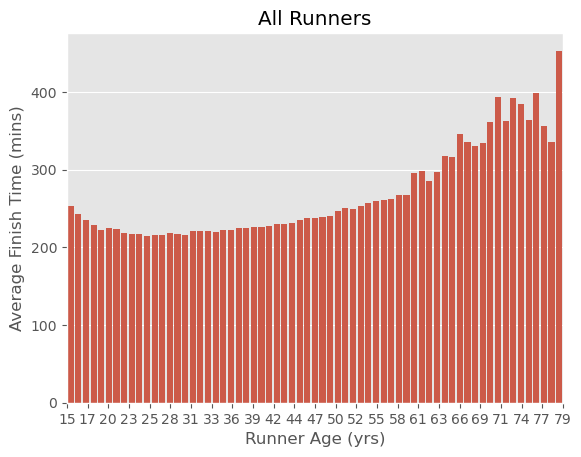

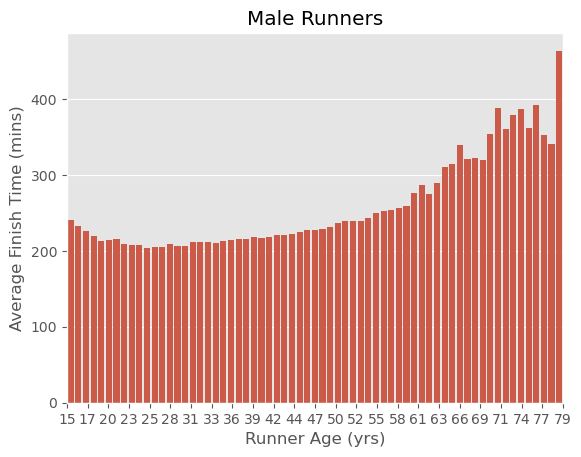

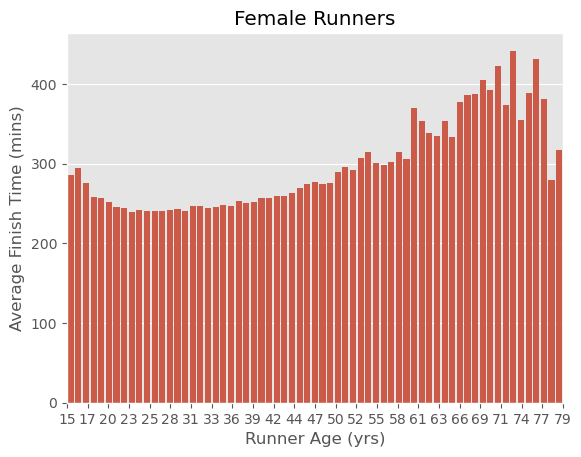

In [201]:
#Generate plots for the average finish time for each age. I will create one plot for all runners, one for men, and one for women.

axis = sns.barplot(x='age', y='time_total_minutes', data=avg_all)
plt.xlabel('Runner Age (yrs)')
plt.ylabel('Average Finish Time (mins)')
plt.title('All Runners')
axis.xaxis.set_major_locator(ticker.LinearLocator(25))
plt.show()

axis = sns.barplot(x='age', y='time_total_minutes', data=avg_male)
plt.xlabel('Runner Age (yrs)')
plt.ylabel('Average Finish Time (mins)')
plt.title('Male Runners')
axis.xaxis.set_major_locator(ticker.LinearLocator(25))
plt.show()

axis = sns.barplot(x='age', y='time_total_minutes', data=avg_female)
plt.xlabel('Runner Age (yrs)')
plt.ylabel('Average Finish Time (mins)')
plt.title('Female Runners')
axis.xaxis.set_major_locator(ticker.LinearLocator(25))
plt.show()

In [203]:
# I will now group runners into 5 year age ranges
group_all = avg_all.copy()
group_male = avg_male.copy()
group_female = avg_female.copy()

# I will use floor division to seperate the data out into ranges of 5 years
group_all['age_range'] = group_all['age'] // 5
group_male['age_range'] = group_male['age'] // 5
group_female['age_range'] = group_female['age'] // 5

#Take the average finish time for each age range
group_all = group_all.groupby('age_range', as_index=False).agg({'time_total_minutes': 'mean'})
group_male = group_male.groupby('age_range', as_index=False).agg({'time_total_minutes': 'mean'})
group_female = group_female.groupby('age_range', as_index=False).agg({'time_total_minutes': 'mean'})

# I will create a label column that can be used for the plot to identify what age range is represented
def create_label(age):
    return str(age*5) + '-' + str(age*5 + 4)

group_all['label'] = group_all['age_range'].apply(lambda x: create_label(x))
group_male['label'] = group_male['age_range'].apply(lambda x: create_label(x))
group_female['label'] = group_female['age_range'].apply(lambda x: create_label(x))

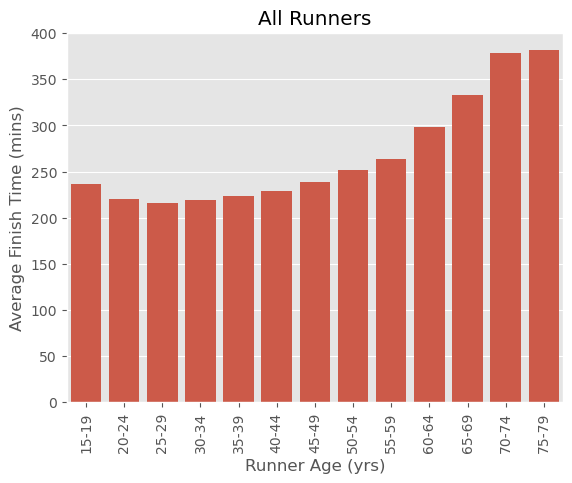

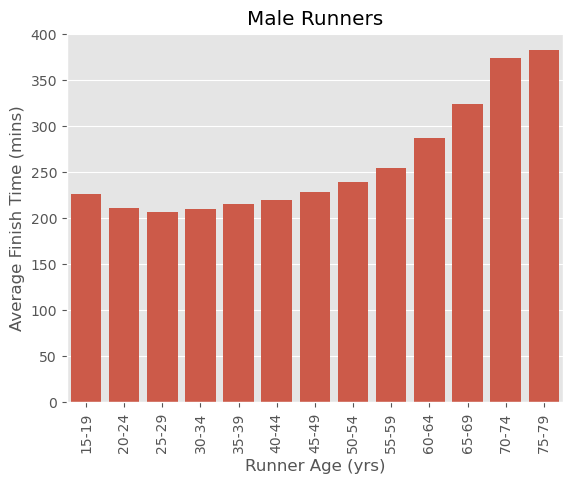

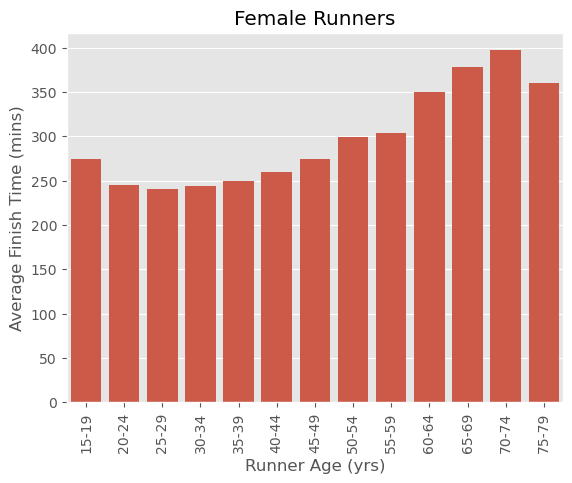

In [423]:
#Generate plots for the average finish time for each age range. I will create one plot for all runners, one for men, and one for women.

axis = sns.barplot(x='label', y='time_total_minutes', data=group_all)
plt.xlabel('Runner Age (yrs)')
plt.ylabel('Average Finish Time (mins)')
plt.title('All Runners')
plt.xticks(rotation=90)
plt.show()

axis = sns.barplot(x='label', y='time_total_minutes', data=group_male)
plt.xlabel('Runner Age (yrs)')
plt.ylabel('Average Finish Time (mins)')
plt.title('Male Runners')
plt.xticks(rotation=90)
plt.show()

axis = sns.barplot(x='label', y='time_total_minutes', data=group_female)
plt.xlabel('Runner Age (yrs)')
plt.ylabel('Average Finish Time (mins)')
plt.title('Female Runners')
plt.xticks(rotation=90)
plt.show()

In [425]:
#I also want to plot the results of the 100 fastest finishers to see if their distibution matches the general publics distribution.

#Sort the data into by fastest time and then return only the 100 fastest
fastest = df.sort_values(by=['time_total_minutes'], ascending=True)
fastest = fastest.head(100)

In [286]:
#Create a count of how many runners in the top 100 exist in each age
fastest_count = fastest.groupby(['age']).size().to_frame('count')

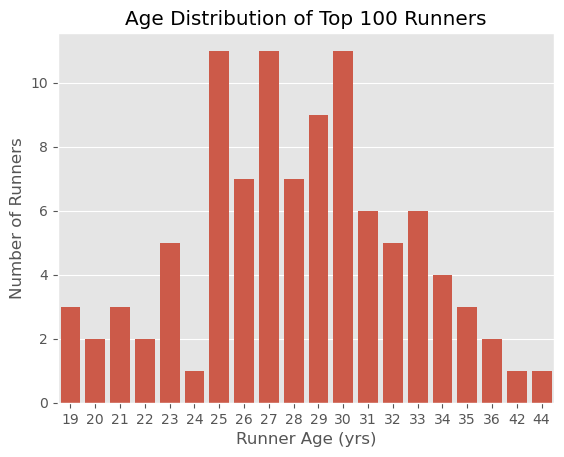

In [298]:
#Create a plot for the fastest 100 marathon runners
axis = sns.barplot(x='age', y='count', data=fastest_count)
plt.xlabel('Runner Age (yrs)')
plt.ylabel('Number of Runners')
plt.title('Age Distribution of Top 100 Runners')
plt.show()

In [ ]:
# It looks like both across the data set as a whole, and within the top finishers, the prime age for competeting in marathons is between 25-30.
# For general runners it appears performance doesn't change all that much between 20-34, with performance starting to more
# noticably decrease around the age of 35. However, for high level runners in the top 100, performance appaears to decrease more rapidly after the
# age of 30.

# The effects of ageing on marathon performance are quite similar with men and women, gender does not appear to play much of a role.
